## make a file that has date, expid, ffrac, fwhm
I also added exposure time in case some of the old gfadiq fits files got put in here as well

In [124]:
from astropy.io import fits
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import json
import collections
from pathlib import Path

import fitsio

import desietcimg.util
from astropy.stats import sigma_clip
import astropy.table 

import pandas as pd

In [2]:
!fitsinfo /global/cfs/cdirs/desi/users/ameisner/GFA/offline_all_guide_frames_thru_20200308.fits

Filename: /global/cfs/cdirs/desi/users/ameisner/GFA/offline_all_guide_frames_thru_20200308.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    224   523462R x 101C   [D, D, K, D, D, D, D, D, D, K, D, D, D, D, D, D, K, D, D, D, D, D, D, K, D, D, D, D, D, D, K, D, D, D, D, 6A, D, 4E, B, K, D, 94A, D, D, 8A, 8A, 4A, D, D, D, K, D, D, K, 37A, D, K, D, D, 97A, 7A, 6A, D, D, K, D, D, D, D, D, D, K, 4K, 4E, 4E, D, D, D, D, K, 2K, 4D, 2D, 2D, 2D, 16A, D, D, 2D, 114A, B, D, D, D, D, 4D, D, D, B, 4K, 4B]   


In [98]:
def get_ffrac_fwhm(month, month_abbrev, output_file = True):
    #create the file that we will write to at the end
    if output_file == True:
        f_out = open(f'fwhm_ffrac_data_{month_abbrev}.txt', mode = 'w')
        f_out_verbose = open(f'fwhm_ffrac_prints_{month_abbrev}.txt', mode = 'w')
        f_out_weird = open(f'fwhm_ffrac_weird_{month_abbrev}.txt', mode = 'w')
    
    #creating a new file to test if things are working
#     f_out_test = open(f'fwhm_ffrac_data_test.txt', mode = 'w')
    
    #initialize final ffrac and fwhm arrays
    ffrac, fwhm = [], []
    
    #pull .fits files from home directory
    directory = f'/global/u1/a/abault/gfadiq/{month}/fits/'
    
    #set a guides array with names of each guide to loop over
    guides = ['GUIDE0', 'GUIDE2', 'GUIDE3', 'GUIDE5', 'GUIDE7', 'GUIDE8']
    
    #trying something else, initialize an array to store the directory, filename
    paths = []
    
    #loop over files in directory, saving the files to an array
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
            paths.append(os.path.join(directory, filename))
    
    #create the PSFMeasure instance (only once - takes less time)
    M = None
    
    #loop over files in paths to pull data from each file
    for i in range(len(paths)):
        f = fits.open(paths[i])
        header = f['PRIMARY'].header
        night = header['NIGHT']
        expid = header['EXPID']
        exptime = header['EXPTIME']
        program = header['PROGRAM']
        if i%100==0:
            print(i)
        #pull only those whose observation type is science
        #also maybe we don't want focus scans?
#         directory2 = f'/global/cfs/cdirs/desi/spectro/data/'
#         if f'gfa-000{expid}.fits.fz' in os.listdir(os.path.join(directory2, f'{night}/000{expid}/')):
#             file2 = f'{night}/000{expid}/gfa-000{expid}.fits.fz'
#             second_file = os.path.join(directory2, file2)
#             f2 = fits.open(second_file)
#             f2_gfa = f2['GFA'].header
#         if f'guide-000{expid}.fits.fz' in os.listdir(os.path.join(directory2, f'{night}/000{expid}/')):
#             file2 = f'{night}/000{expid}/guide-000{expid}.fits.fz'
#             second_file = os.path.join(directory2, file2)
#             f2 = fits.open(second_file)
#             f2_guide = f2['GUIDER'].header
#         if f2_gfa['FLAVOR'] == 'science' or f2_guide['FLAVOR '] == 'science':
#             #cut out the exposures that do 'focus scan'
#             if 'focus' in f2_gfa['PROGRAM'] or 'focus' in f2_guide['PROGRAM']:
#                 continue
            #in case some of the older files (with a small exptime) were inlcuded
#             if exptime < 5.0:
#                 continue
        if 'focus' in program:
            continue
    
    #initialize the single exposure ffrac and fwhm arrays (this resets after each exposure)
        ffrac_expid, fwhm_expid = [], []
        #loop over guide GFAs
        for j in range(len(guides)):
            #only use guides within the fits file (not all files have all guides)
            if guides[j] not in f:
                if output_file == True:
                    print(night, expid, paths[i], 'is missing', guides[j], file = f_out_verbose)
                continue
            #pull the data from each guide
            data = f[guides[j]].data
            #only take guides that have data of the correct shape (some guides don't have data i.e., no stars)
            #this is not working if the entire file has no data
            if len(data.shape) != 3:
                continue
            #initialize the instance (this will only happen the first time through the loop)
            if M is None:
                M = desietcimg.util.PSFMeasure(data.shape[1])
            #pull out fwhm and ffrac for each guide using PSFMeasure.measure
            fwhm_, ffrac_ = M.measure(data[0],data[1])
            if fwhm_ == -1:
                continue
            #append the fwhm and ffrac data for each guide to an array (this is for a single exposure, will reset after each exposure)  
            ffrac_expid.append(ffrac_)
            fwhm_expid.append(fwhm_)
        #take the average of the ffrac and fwhm arrays for each exposure
        ffrac_exp_avg = np.nanmean(ffrac_expid)
        fwhm_exp_avg = np.nanmean(fwhm_expid)
        if ffrac_exp_avg >1.0 or ffrac_exp_avg < 0.0:
            if output_file == True:
#                 print(f"{night},{expid},{exptime},{ffrac_exp_avg},{fwhm_exp_avg},{f2_gfa['PROGRAM']}", file = f_out_weird)
                print(f"{night},{expid},{exptime},{ffrac_exp_avg},{fwhm_exp_avg},{program}", file = f_out_weird)
            continue
        if np.isnan(ffrac_exp_avg) == True or np.isnan(fwhm_exp_avg) == True:
            continue
        if output_file == True:
#             print(f"{night},{expid},{exptime},{ffrac_exp_avg},{fwhm_exp_avg},{f2_gfa['PROGRAM']}", file = f_out)
            print(f"{night},{expid},{exptime},{ffrac_exp_avg},{fwhm_exp_avg},{program}", file = f_out)
        #append the average fwhm and ffrac of each exposure to an array
        ffrac.append(ffrac_exp_avg)
        fwhm.append(fwhm_exp_avg)
            #maybe create a "row" array for each ffrac and fwhm, then use vstack for it?

    return ffrac, fwhm

In [99]:
ffrac_mar, fwhm_mar = get_ffrac_fwhm(month = 'march', month_abbrev = 'mar', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200


In [100]:
ffrac_feb, fwhm_feb = get_ffrac_fwhm(month = 'february', month_abbrev = 'feb', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [101]:
ffrac_jan, fwhm_jan = get_ffrac_fwhm(month = 'january', month_abbrev = 'jan', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


In [102]:
ffrac_dec, fwhm_dec = get_ffrac_fwhm(month = 'december', month_abbrev = 'dec', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900
1000
1100
1200


In [103]:
ffrac_nov, fwhm_nov = get_ffrac_fwhm(month = 'november', month_abbrev = 'nov', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [104]:
ffrac_oct, fwhm_oct = get_ffrac_fwhm(month = 'october', month_abbrev = 'oct', output_file = True)

0


/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


### read in ETC data

In [106]:
gfadiq = pd.read_csv('fwhm_ffrac_data_all.csv')
gfadiq.describe()

,night,expid,exptime,ffrac,fwhm
count,5.880000e+03,5880.000000,5880.000000,5880.000000,5880.000000
mean,2.019511e+07,34633.156122,31.877313,0.516898,1.326668
std,4.497928e+03,10313.565333,48.494500,0.177633,0.587209
min,2.019102e+07,19992.000000,1.000000,0.029193,0.176562
25%,2.019111e+07,24978.500000,10.000000,0.396510,0.961803
50%,2.019122e+07,32849.500000,15.000000,0.555773,1.131614
75%,2.020012e+07,44168.750000,30.000000,0.652702,1.515195
max,2.020032e+07,55692.000000,300.000000,0.982976,6.366134


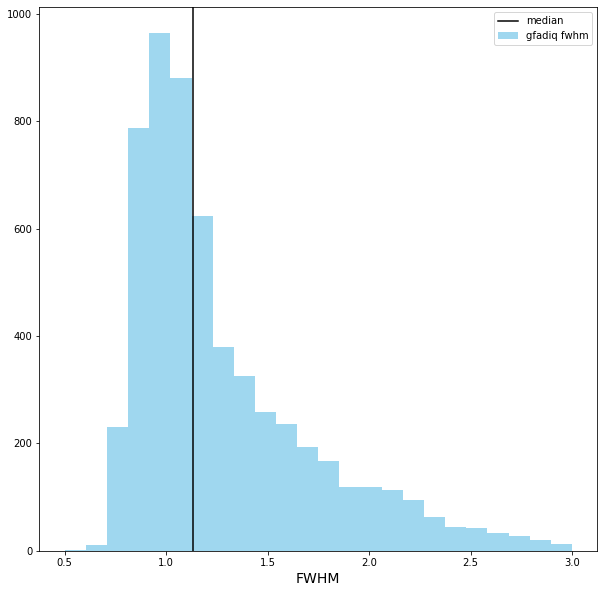

In [119]:
plt.figure(figsize = (10,10))
plt.hist(gfadiq['fwhm'], bins = np.linspace(0.5,3,25), color = 'skyblue', alpha = 0.8, label = 'gfadiq fwhm')
plt.axvline(np.median(gfadiq['fwhm']), color = 'black', label = 'median')
plt.legend()
plt.xlabel('FWHM', fontsize = 14);

### read in guider data

In [165]:
guider = pd.read_csv('guide_data.csv').rename(columns = {'exp_id':'expid'})
# guider.rename(columns = {'exp_id':'expid'})
guider.describe()

,Unnamed: 0,expid,guide_rms,guide_rms_ra,guide_rms_dec,centroids_rms_ra,centroids_rms_dec,centroids_std_ra,centroids_std_dec,field_rotation_rate,field_rotation_init,psf_fwhm,psf_fwhm_std,psf_fit,effective_seeing
count,1671.000000,1671.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1668.000000,1671.000000,1671.000000,1638.000000,1638.000000,1671.000000,1635.000000
mean,835.000000,41623.922801,231.427039,167.311097,151.490514,156.147675,149.311415,55.396445,56.547058,-0.359656,9.520577,1.301132,0.102494,15.506816,1.330363
std,482.520466,7892.636058,246.376119,168.660698,186.741601,210.250323,172.391862,106.573481,102.337747,65.775668,377.533460,0.419640,0.079931,122.703902,0.434630
min,0.000000,20292.000000,46.018054,28.237900,17.080167,8.324327,13.726954,0.043759,0.045241,-2004.818276,-1051.588975,0.714697,0.000000,0.013084,0.723970
25%,417.500000,37761.500000,129.383082,99.029240,73.015008,75.907099,69.535896,17.002004,16.821402,-0.520680,-1.448192,1.037950,0.051773,0.046301,1.053540
50%,835.000000,43864.000000,163.115172,124.983306,99.757160,107.626216,101.484568,26.425400,26.562181,-0.330525,-0.014602,1.168637,0.078539,0.102589,1.191894
75%,1252.500000,47772.500000,223.926190,165.474507,146.183345,170.876625,159.193340,51.659401,49.780068,0.000000,1.323278,1.435411,0.127296,0.369798,1.475812
max,1670.000000,52978.000000,3221.129557,2378.927325,2171.722912,3823.956923,2930.342756,1995.110075,1657.278602,1669.585455,14921.233201,3.401532,0.710055,2254.405261,3.547330


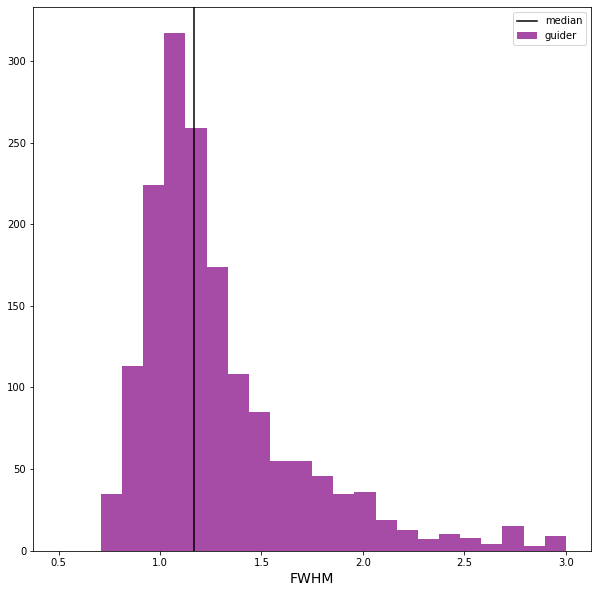

In [144]:
plt.figure(figsize = (10,10))
plt.hist(guider['psf_fwhm'], bins = np.linspace(0.5,3,25), color = 'purple', label = 'guider', alpha = 0.7)
plt.axvline(np.nanmedian(guider['psf_fwhm']), color = 'black', label = 'median')
plt.legend()
plt.xlabel('FWHM', fontsize = 14);

### read in offline data

In [128]:
offline = astropy.table.Table.read('/global/cfs/cdirs/desi/users/ameisner/GFA/offline_all_guide_frames_thru_20200308.fits', hdu=1)

In [129]:
offline.columns

<TableColumns names=('MEDIAN','MEAN','N_NON_FINITE','MAX','MIN','SIG_ROBUST','SIG','MEDIAN_Q1','MEAN_Q1','N_NON_FINITE_Q1','MAX_Q1','MIN_Q1','SIG_ROBUST_Q1','SIG_Q1','MEDIAN_Q2','MEAN_Q2','N_NON_FINITE_Q2','MAX_Q2','MIN_Q2','SIG_ROBUST_Q2','SIG_Q2','MEDIAN_Q3','MEAN_Q3','N_NON_FINITE_Q3','MAX_Q3','MIN_Q3','SIG_ROBUST_Q3','SIG_Q3','MEDIAN_Q4','MEAN_Q4','N_NON_FINITE_Q4','MAX_Q4','MIN_Q4','SIG_ROBUST_Q4','SIG_Q4','CAMERA','SKY_MAG_AB','SKY_MAG_AB_PER_AMP','PETAL_LOC','EXPID','MJD','PROGRAM','SKYRA','SKYDEC','DOMSHUTL','DOMSHUTU','PMCOVER','MOONRA','MOONDEC','T_C_FOR_DARK','T_C_FOR_DARK_IS_GUESS','TIME_S_FOR_DARK','AIRMASS','NIGHT','FOCUS','EXPTIME','CUBE_INDEX','RACEN','DECCEN','FNAME_RAW','GITREV','EXTNAME','CONTRAST','FIBER_FRACFLUX','N_SOURCES_FOR_PSF','APER_CORR_FAC','XCENTROID_PSF','YCENTROID_PSF','MOON_SEP_DEG','ZP_ADU_PER_S','TRANSPARENCY','NPIX_BAD_TOTAL','NPIX_BAD_PER_AMP','OVERSCAN_MEDIANS_ADU','PRESCAN_MEDIANS_ADU','FWHM_MAJOR_PIX','FWHM_MINOR_PIX','FWHM_PIX','FWHM_ASEC','N_SO

In [220]:
offline_df = offline[['EXPID','FWHM_ASEC','EXPTIME','N_SOURCES_FOR_PSF','NPIX_BAD_TOTAL','FIBER_FRACFLUX', 'MJD','AIRMASS','TRANSPARENCY']].to_pandas()

In [223]:
offline2 = offline_df.groupby('EXPID').median().reset_index().rename(columns={'EXPID':'expid'})
offline2

,expid,FWHM_ASEC,EXPTIME,N_SOURCES_FOR_PSF,NPIX_BAD_TOTAL,FIBER_FRACFLUX,MJD,AIRMASS,TRANSPARENCY
0,20292,0.863078,5.0,99.0,0.0,0.715756,58780.200319,1.117525,0.981801
1,20293,0.916683,5.0,96.5,0.0,0.685176,58780.210256,1.173876,0.985705
2,20294,0.887707,5.0,97.5,0.0,0.711191,58780.212202,1.180718,0.983377
3,20295,0.890122,5.0,100.0,0.0,0.701795,58780.215206,1.187830,0.983392
4,20296,0.864527,5.0,99.5,0.0,0.721453,58780.219122,1.205662,0.982749
...,...,...,...,...,...,...,...,...,...
2166,54491,1.597618,0.0,17.0,0.0,0.379157,58917.437114,1.388916,0.959681
2167,54492,1.541598,0.0,18.0,0.0,0.405749,58917.441364,1.359632,0.960005
2168,54493,1.629492,0.0,17.0,0.0,0.385465,58917.445602,1.332259,0.957157
2169,54494,1.819284,0.0,16.0,0.0,0.298969,58917.449866,1.306591,0.943017


In [232]:
offline2.sort_values(by = 'TRANSPARENCY')

,expid,FWHM_ASEC,EXPTIME,N_SOURCES_FOR_PSF,NPIX_BAD_TOTAL,FIBER_FRACFLUX,MJD,AIRMASS,TRANSPARENCY
2018,52429,1.175052,5.0,1.0,0.0,0.494986,58907.332519,1.223325,0.023334
1054,42302,1.431490,5.0,2.0,0.0,0.367367,58868.361356,1.034213,0.024582
360,30935,1.606794,5.0,0.5,0.0,0.197190,58824.344428,1.401195,0.038125
2019,52433,1.165877,5.0,2.0,0.0,0.531877,58907.352813,1.320981,0.043469
280,29783,1.594238,10.0,6.0,0.0,0.385230,58812.295010,1.628964,0.059372
...,...,...,...,...,...,...,...,...,...
325,30732,1.712556,1.0,8.5,0.0,0.281187,58823.148100,1.123375,36.080987
322,30726,4.392350,1.0,1.0,0.0,0.065870,58823.059247,3.455264,55.349032
324,30731,1.552223,1.0,10.0,0.0,0.372148,58823.138967,1.097536,115.492306
361,30936,2.062683,5.0,0.0,0.0,0.231650,58824.351540,1.351991,NaN


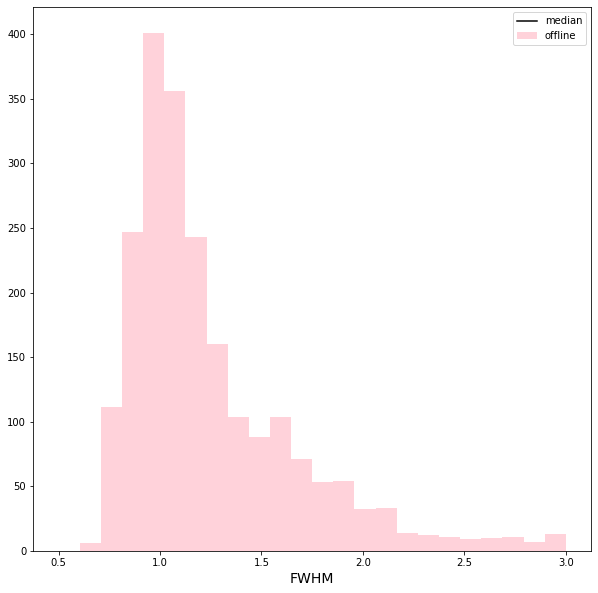

In [185]:
plt.figure(figsize = (10,10))
plt.hist(offline2['FWHM_ASEC'], bins = np.linspace(0.5,3,25), color = 'pink', alpha = 0.7, label = 'offline')
plt.axvline(np.median(offline2['FWHM_ASEC']), color = 'black', label = 'median')
plt.legend()
plt.xlabel('FWHM', fontsize = 14);

#### join all 3 histograms together

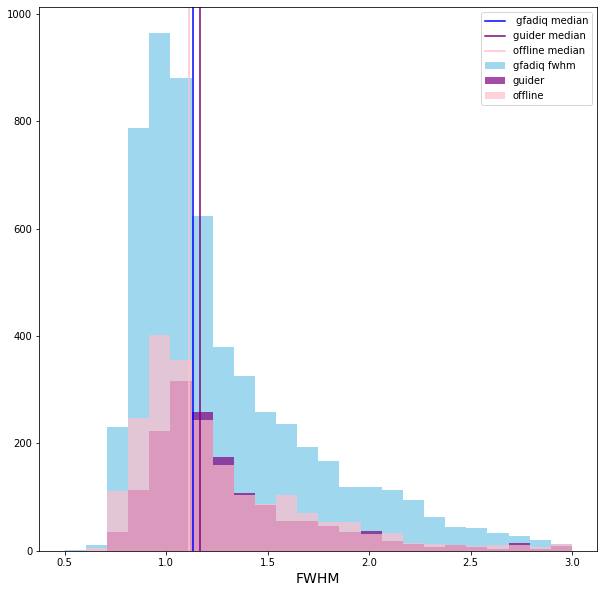

In [186]:
plt.figure(figsize = (10,10))
plt.hist(gfadiq['fwhm'], bins = np.linspace(0.5,3,25), color = 'skyblue', alpha = 0.8, label = 'gfadiq fwhm')
plt.axvline(np.median(gfadiq['fwhm']), color = 'blue', label = ' gfadiq median')

plt.hist(guider['psf_fwhm'], bins = np.linspace(0.5,3,25), color = 'purple', label = 'guider', alpha = 0.7)
plt.axvline(np.nanmedian(guider['psf_fwhm']), color = 'purple', label = 'guider median')

plt.hist(offline2['FWHM_ASEC'], bins = np.linspace(0.5,3,25), color = 'pink', alpha = 0.7, label = 'offline')
plt.axvline(np.nanmedian(offline2['FWHM_ASEC']), color = 'pink', label = 'offline median')
plt.legend()
plt.xlabel('FWHM', fontsize = 14);

## join guider & gfadiq, and offline & gfadiq

In [224]:
offline_gfadiq = offline2.set_index('expid').join(gfadiq.set_index('expid'), how = 'inner', on = 'expid')
offline_gfadiq

,FWHM_ASEC,EXPTIME,N_SOURCES_FOR_PSF,NPIX_BAD_TOTAL,FIBER_FRACFLUX,MJD,AIRMASS,TRANSPARENCY,night,exptime,ffrac,fwhm,program,extra,moreextra
expid,,,,,,,,,,,,,,,
29405,1.513105,5.0,19.5,0.0,0.347142,58810.303225,1.000484,0.978172,20191122,10.0,0.433480,1.369122,Commissioning,NaN,NaN
29406,1.402031,5.0,20.0,0.0,0.411923,58810.312527,1.002280,0.872689,20191122,10.0,0.407602,1.432963,Commissioning,NaN,NaN
29407,1.408792,5.0,18.0,0.0,0.412449,58810.321842,1.007700,0.970156,20191122,10.0,0.381099,1.505518,Commissioning,NaN,NaN
29408,1.448392,5.0,17.0,0.0,0.410687,58810.327928,1.013485,1.009210,20191122,10.0,0.340694,1.700447,Commissioning,NaN,NaN
29424,1.447426,5.0,12.0,0.0,0.384717,58810.355754,1.258811,0.897608,20191122,5.0,0.342673,1.661002,Commissioning,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54490,1.736703,0.0,16.0,0.0,0.338284,58917.432853,1.420356,0.958892,20200308,15.0,0.312065,1.809611,Dither fibermode tile 63305 (260,20),NaN
54491,1.597618,0.0,17.0,0.0,0.379157,58917.437114,1.388916,0.959681,20200308,15.0,0.356863,1.648071,Dither fibermode tile 63306 (260,20),NaN
54492,1.541598,0.0,18.0,0.0,0.405749,58917.441364,1.359632,0.960005,20200308,15.0,0.372887,1.625009,Dither fibermode tile 63307 (260,20),NaN


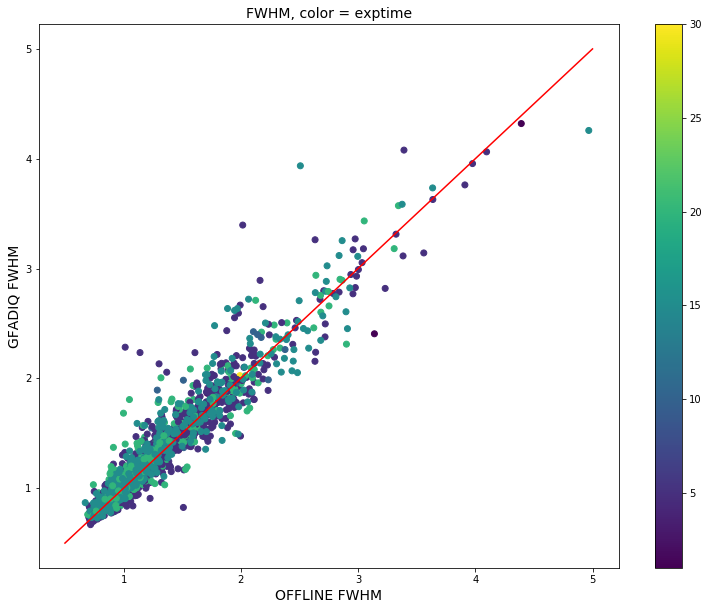

In [174]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['exptime'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = exptime', fontsize = 14)
plt.colorbar();

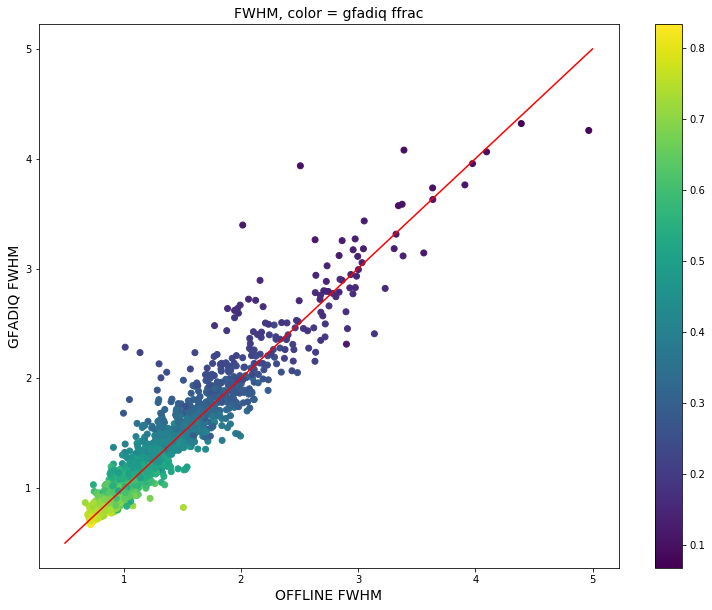

In [173]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['ffrac'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = gfadiq ffrac', fontsize = 14)
plt.colorbar();

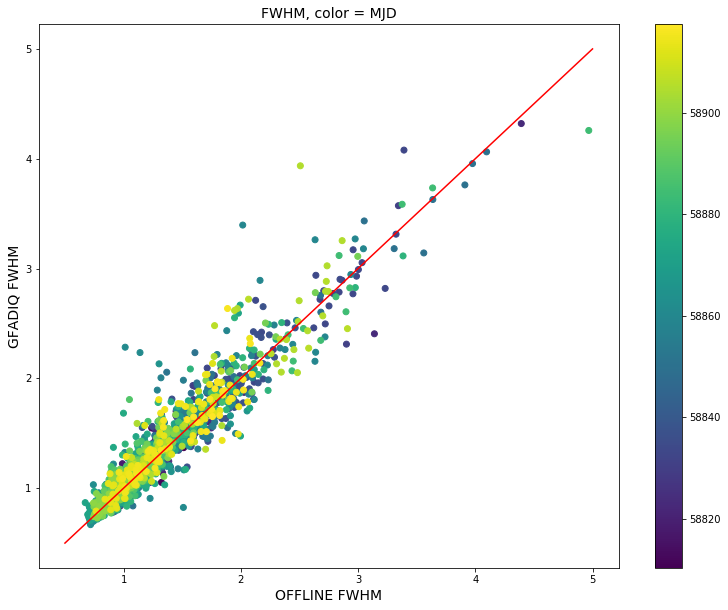

In [188]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['MJD'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = MJD', fontsize = 14)
plt.colorbar();

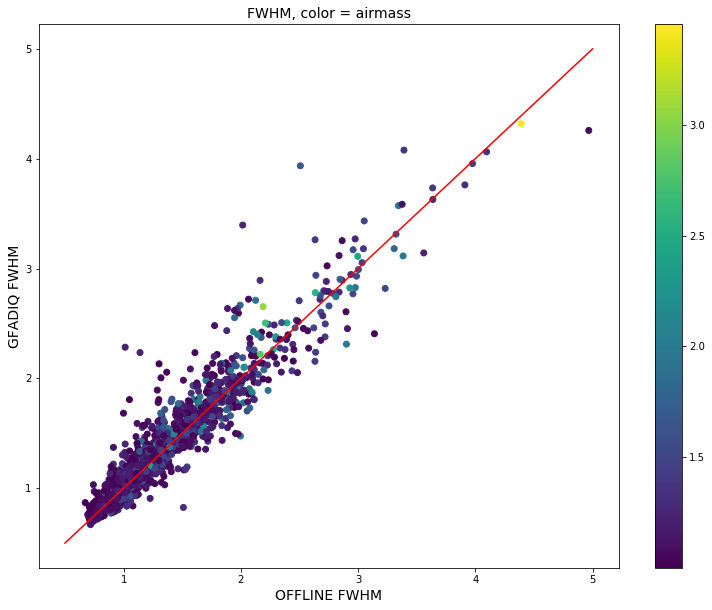

In [225]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['AIRMASS'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = airmass', fontsize = 14)
plt.colorbar();

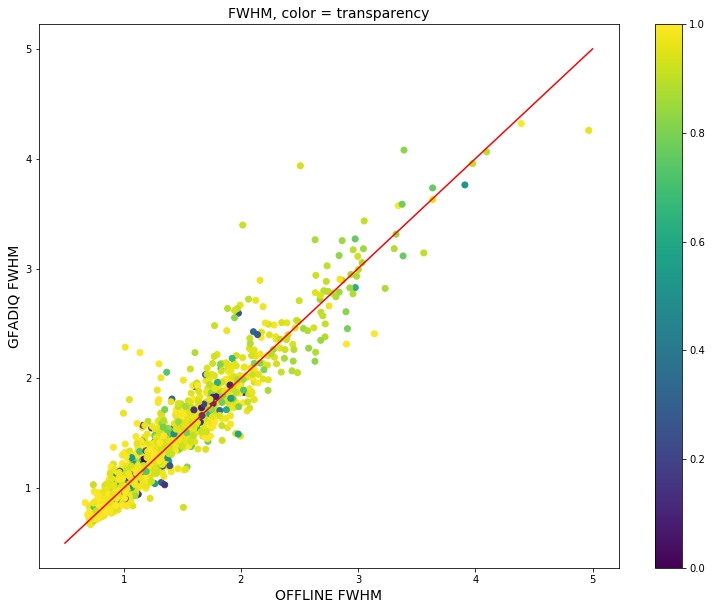

In [236]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['TRANSPARENCY'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = transparency', fontsize = 14)
plt.clim(0,1)
plt.colorbar();

In [ ]:
plt.figure(figsize = (13,10))
plt.scatter(offline_gfadiq['FWHM_ASEC'], offline_gfadiq['fwhm'], c = offline_gfadiq['MJD'])
plt.plot([0.5, 5], [0.5, 5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = MJD', fontsize = 14)
plt.colorbar();

In [189]:
guider_gfadiq = guider.set_index('expid').join(gfadiq.set_index('expid'), how = 'inner', on = 'expid')
guider_gfadiq

,Unnamed: 0,date,guide_rms,guide_rms_ra,guide_rms_dec,centroids_rms_ra,centroids_rms_dec,centroids_std_ra,centroids_std_dec,field_rotation_rate,...,psf_fwhm_std,psf_fit,effective_seeing,night,exptime,ffrac,fwhm,program,extra,moreextra
expid,,,,,,,,,,,,,,,,,,,,,
52978,0,2020-03-04 10:40:37.145105,180.936939,143.128081,110.691139,213.896152,172.331226,78.665931,60.212844,0.159544,...,0.138780,0.083681,1.406884,20200303,15.0,0.406641,1.502319,ELG tile 70005 (1 of 2),NaN,NaN
52961,1,2020-03-04 09:48:35.758708,194.273858,146.894116,127.139493,68.632267,51.774624,16.152941,20.291137,0.005498,...,0.174647,0.050832,1.281688,20200303,15.0,0.375312,1.571099,QSO+LRG tile 70002 (1 of 2),NaN,NaN
52942,2,2020-03-04 08:51:36.060833,144.906716,111.484940,92.569242,207.885269,128.095691,78.014891,41.739571,0.196383,...,0.146072,0.049723,1.361929,20200303,15.0,0.504272,1.238857,MW+BGS tile 70500 (1 of 2),NaN,NaN
52940,3,2020-03-04 08:26:46.912133,180.599114,129.230656,126.156559,173.237553,118.262635,49.928466,35.297385,0.101608,...,0.227668,0.042054,1.513334,20200303,15.0,0.462106,1.308191,MW+BGS tile 70500 (1 of 2),NaN,NaN
52938,4,2020-03-04 08:03:39.226972,174.682020,133.211653,112.997627,173.046145,102.732351,48.219405,30.094205,0.137001,...,0.140105,0.040072,1.366625,20200303,15.0,0.561401,1.142660,MW+BGS tile 70500 (1 of 2),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29425,1501,2019-11-23 08:45:00.199341,241.802957,166.998328,174.872035,291.972959,231.319789,29.041483,24.775640,-0.161835,...,0.136593,0.046775,1.338862,20191122,5.0,0.437630,1.432070,Commissioning,NaN,NaN
29424,1502,2019-11-23 08:35:21.241151,275.625456,158.343231,225.603221,303.774560,230.897330,41.089103,23.131713,-0.207608,...,0.197077,0.074266,1.529829,20191122,5.0,0.342673,1.661002,Commissioning,NaN,NaN
29408,1503,2019-11-23 07:53:50.767065,225.805259,149.929362,168.846681,73.341805,68.862707,24.202626,24.340139,-0.280597,...,0.109084,0.907730,1.469418,20191122,10.0,0.340694,1.700447,Commissioning,NaN,NaN


In [190]:
guider_gfadiq.columns

Index(['Unnamed: 0', 'date', 'guide_rms', 'guide_rms_ra', 'guide_rms_dec',
       'centroids_rms_ra', 'centroids_rms_dec', 'centroids_std_ra',
       'centroids_std_dec', 'field_rotation_rate', 'field_rotation_init',
       'psf_fwhm', 'psf_fwhm_std', 'psf_fit', 'effective_seeing', 'night',
       'exptime', 'ffrac', 'fwhm', 'program', 'extra', 'moreextra'],
      dtype='object')

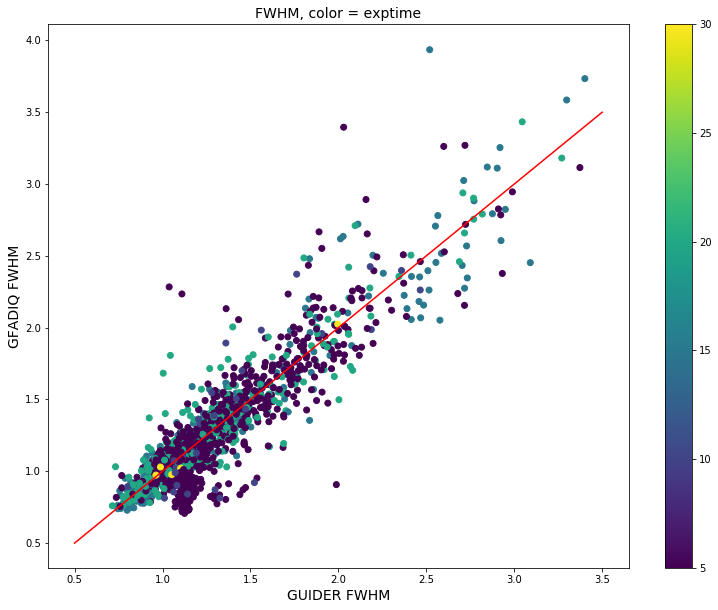

In [177]:
plt.figure(figsize = (13,10))
plt.scatter(guider_gfadiq['psf_fwhm'], guider_gfadiq['fwhm'], c = guider_gfadiq['exptime'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('GUIDER FWHM', fontsize =14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = exptime', fontsize = 14)
plt.colorbar();

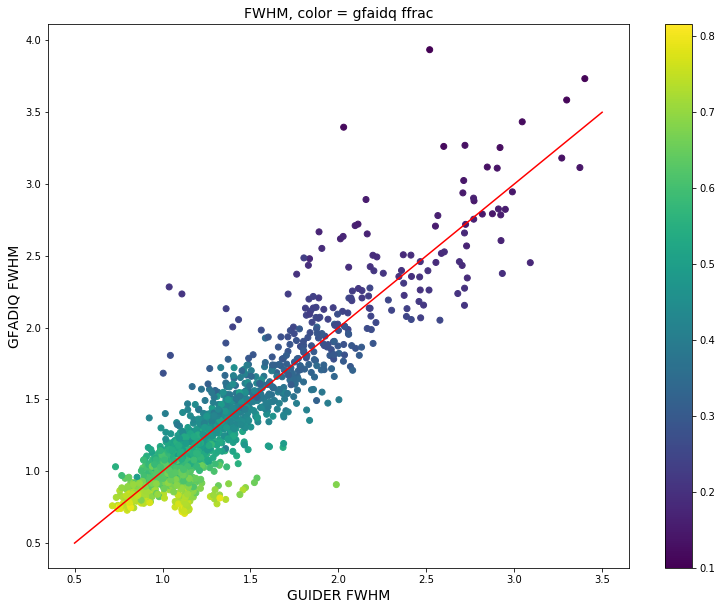

In [176]:
plt.figure(figsize = (13,10))
plt.scatter(guider_gfadiq['psf_fwhm'], guider_gfadiq['fwhm'], c = guider_gfadiq['ffrac'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('GUIDER FWHM', fontsize =14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = gfaidq ffrac', fontsize = 14)
plt.colorbar();

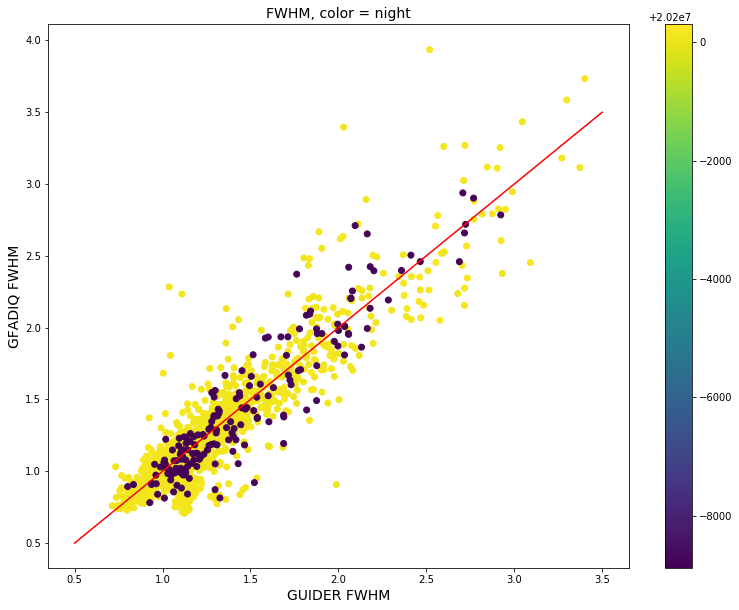

In [182]:
plt.figure(figsize = (13,10))
plt.scatter(guider_gfadiq['psf_fwhm'], guider_gfadiq['fwhm'], c = guider_gfadiq['night'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('GUIDER FWHM', fontsize =14)
plt.ylabel('GFADIQ FWHM', fontsize = 14)
plt.title('FWHM, color = night', fontsize = 14)
plt.colorbar();

In [193]:
offline_guider = offline2.set_index('expid').join(guider.set_index('expid'), how = 'inner', on = 'expid')
offline_guider

,FWHM_ASEC,EXPTIME,N_SOURCES_FOR_PSF,NPIX_BAD_TOTAL,FIBER_FRACFLUX,MJD,Unnamed: 0,date,guide_rms,guide_rms_ra,...,centroids_rms_ra,centroids_rms_dec,centroids_std_ra,centroids_std_dec,field_rotation_rate,field_rotation_init,psf_fwhm,psf_fwhm_std,psf_fit,effective_seeing
expid,,,,,,,,,,,,,,,,,,,,,
20292,0.863078,5.0,99.0,0.0,0.715756,58780.200319,1670,2019-10-24 04:58:34.704635,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.278122,-0.322480,0.738918,0.026585,1.611769,NaN
20294,0.887707,5.0,97.5,0.0,0.711191,58780.212202,1669,2019-10-24 05:06:16.723566,NaN,NaN,...,NaN,NaN,NaN,NaN,-41.952216,37.886583,0.740213,0.011217,1.705042,NaN
20295,0.890122,5.0,100.0,0.0,0.701795,58780.215206,1668,2019-10-24 05:12:14.833303,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.246064,-3.765414,1.196672,0.070435,1.387076,NaN
20298,0.891088,5.0,99.0,0.0,0.707383,58780.238355,1667,2019-10-24 05:49:59.949590,331.685017,223.711194,...,647.434049,423.971038,135.149360,87.792496,-0.268771,-2.088243,1.272205,0.021239,1.310416,1.314732
20875,1.887861,5.0,14.0,0.0,0.265010,58781.219516,1666,2019-10-25 05:24:10.681027,2183.638377,1985.373907,...,3823.956923,1225.102514,1443.965345,738.389468,0.387710,-3.094800,1.961443,0.150637,0.272581,2.935223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52938,1.284195,5.0,13.0,0.0,0.465487,58912.328329,4,2020-03-04 08:03:39.226972,174.682020,133.211653,...,173.046145,102.732351,48.219405,30.094205,0.137001,1.793353,1.355415,0.140105,0.040072,1.366625
52940,1.410723,5.0,11.0,0.0,0.406432,58912.344461,3,2020-03-04 08:26:46.912133,180.599114,129.230656,...,173.237553,118.262635,49.928466,35.297385,0.101608,2.246454,1.502519,0.227668,0.042054,1.513334
52942,1.306893,5.0,13.0,0.0,0.462821,58912.361501,2,2020-03-04 08:51:36.060833,144.906716,111.484940,...,207.885269,128.095691,78.014891,41.739571,0.196383,0.529860,1.354198,0.146072,0.049723,1.361929


In [214]:
mask = offline_guider['EXPTIME'] > 5

expid
20292    False
20294    False
20295    False
20298    False
20875    False
         ...  
52938    False
52940    False
52942    False
52961    False
52978    False
Name: EXPTIME, Length: 1625, dtype: bool


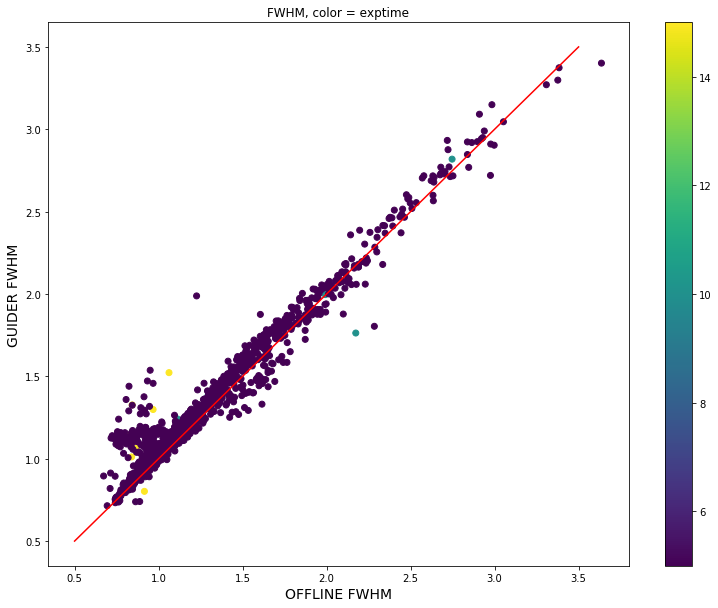

In [216]:
plt.figure(figsize = (13,10))
plt.scatter(offline_guider['FWHM_ASEC'], offline_guider['psf_fwhm'], c = offline_guider['EXPTIME'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GUIDER FWHM', fontsize = 14)
plt.title('FWHM, color = exptime')
plt.colorbar();

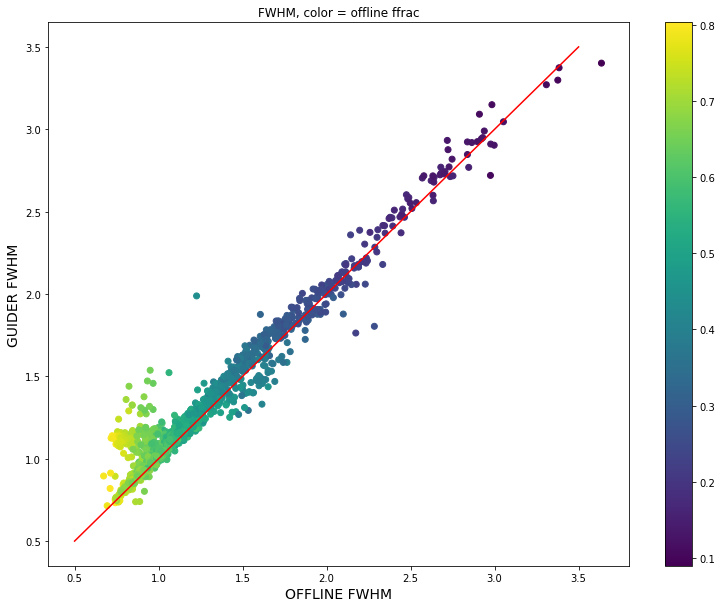

In [202]:
plt.figure(figsize = (13,10))
plt.scatter(offline_guider['FWHM_ASEC'], offline_guider['psf_fwhm'], c = offline_guider['FIBER_FRACFLUX'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GUIDER FWHM', fontsize = 14)
plt.title('FWHM, color = offline ffrac')
plt.colorbar();

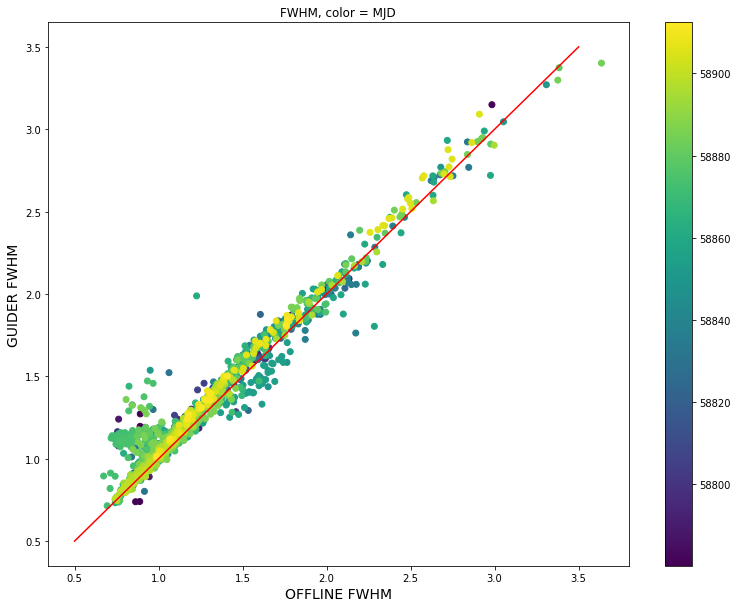

In [203]:
plt.figure(figsize = (13,10))
plt.scatter(offline_guider['FWHM_ASEC'], offline_guider['psf_fwhm'], c = offline_guider['MJD'])
plt.plot([0.5, 3.5], [0.5, 3.5], 'r-')
plt.xlabel('OFFLINE FWHM', fontsize = 14)
plt.ylabel('GUIDER FWHM', fontsize = 14)
plt.title('FWHM, color = MJD')
plt.colorbar();

In [217]:
rms_offline_guider = np.std(offline_guider['FWHM_ASEC']-offline_guider['psf_fwhm'])
print(rms_offline_guider)

0.0967710028471936


In [218]:
rms_offline_gfadiq = np.std(offline_gfadiq['FWHM_ASEC']-offline_gfadiq['fwhm'])
print(rms_offline_gfadiq)

0.1525661965319286


In [219]:
rms_guider_gfadiq = np.std(guider_gfadiq['psf_fwhm']-guider_gfadiq['fwhm'])
print(rms_guider_gfadiq)

0.1914099008927679


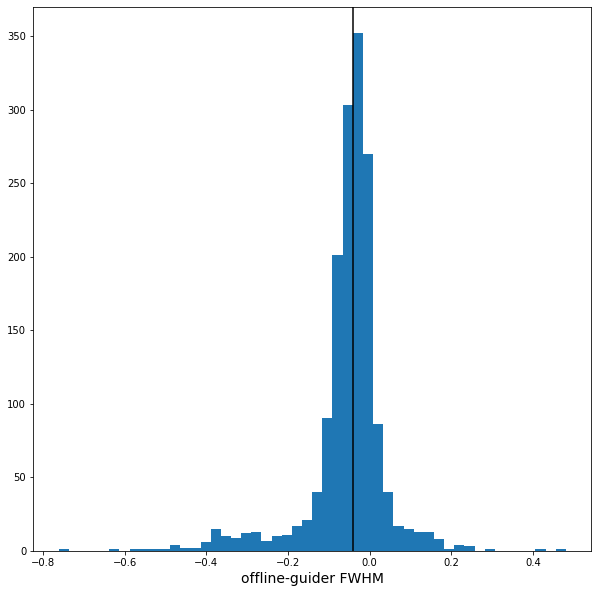

In [210]:
plt.figure(figsize = (10,10))
plt.hist(offline_guider['FWHM_ASEC']-offline_guider['psf_fwhm'], bins = 50)
plt.axvline(np.nanmedian(offline_guider['FWHM_ASEC']-offline_guider['psf_fwhm']), color = 'k')
plt.xlabel('offline-guider FWHM', fontsize = 14);

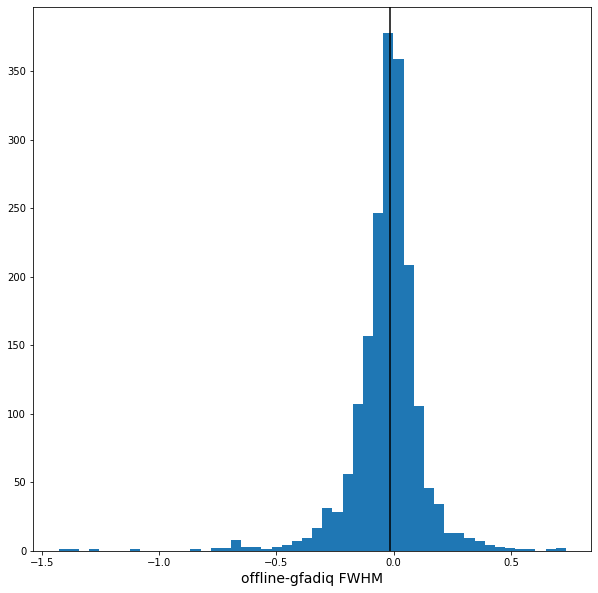

In [207]:
plt.figure(figsize = (10,10))
plt.hist(offline_gfadiq['FWHM_ASEC']-offline_gfadiq['fwhm'], bins = 50)
plt.axvline(np.median(offline_gfadiq['FWHM_ASEC']-offline_gfadiq['fwhm']), color = 'k')
plt.xlabel('offline-gfadiq FWHM', fontsize = 14);

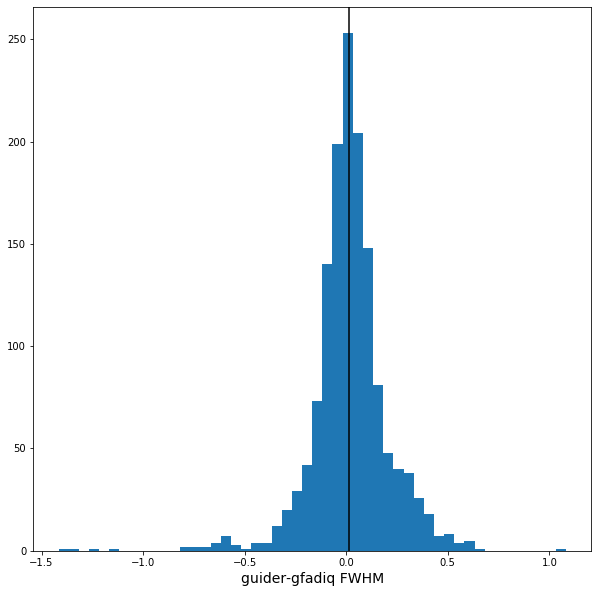

In [213]:
plt.figure(figsize = (10,10))
plt.hist(guider_gfadiq['psf_fwhm']-guider_gfadiq['fwhm'], bins = 50)
plt.axvline(np.nanmedian(guider_gfadiq['psf_fwhm']-guider_gfadiq['fwhm']), color = 'k')
plt.xlabel('guider-gfadiq FWHM', fontsize = 14);

#### make cuts on aaron's data based on the N_SOURCES_FOR_PSF and hot pixels

In [16]:
f = fits.open('/global/cfs/cdirs/desi/users/ameisner/GFA/offline_all_guide_frames_thru_20200308.fits')
data = f[1].data
offline_fwhm = []
offline_ffrac = []
PSFSOURCES = data['N_SOURCES_FOR_PSF']
BADPIX = data['NPIX_BAD_TOTAL']
FWHM = data['FWHM_ASEC']
FFRAC = data['FIBER_FRACFLUX']
for i,line in enumerate(data):
    if PSFSOURCES[i] > 0 or BADPIX[i] < 10:
        offline_fwhm.append(FWHM[i])
        offline_ffrac.append(FFRAC[i])

In [17]:
print(data['N_SOURCES_FOR_PSF']) #use >0
print(data['NPIX_BAD_TOTAL']) #use <10

[102   0 181 ...   0   0   1]
[  0 134   0 ...  10  24   0]


In [27]:
unique_expids = np.unique(offline_expid)
offline_fwhm_avg_per_expid = []
offline_ffrac_avg_per_expid = []
for j in range(len(unique_expids)):
#     print(unique_expids[j])
    mask = (offline_expid == unique_expids[j])
    fwhm_avg = np.nanmean(FWHM[mask])
    ffrac_avg = np.nanmean(FFRAC[mask])
    offline_fwhm_avg_per_expid.append(fwhm_avg)
    offline_ffrac_avg_per_expid.append(ffrac_avg)
#     for i, line in enumerate(offline_expid):
#         mask = ( == unique_expids[j])
#         print(mask)
# for i,line in enumerate(offline_expid):
    
# print(np.unique(offline_expid))

/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/global/homes/a/abault/.conda/envs/desietcimg/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [29]:
np.nanmedian(offline_fwhm_avg_per_expid)
print(np.nanmedian(fwhm_nofocus))
print(np.nanmedian(santi_fwhm))

1.1196208167023955
1.168636895150903


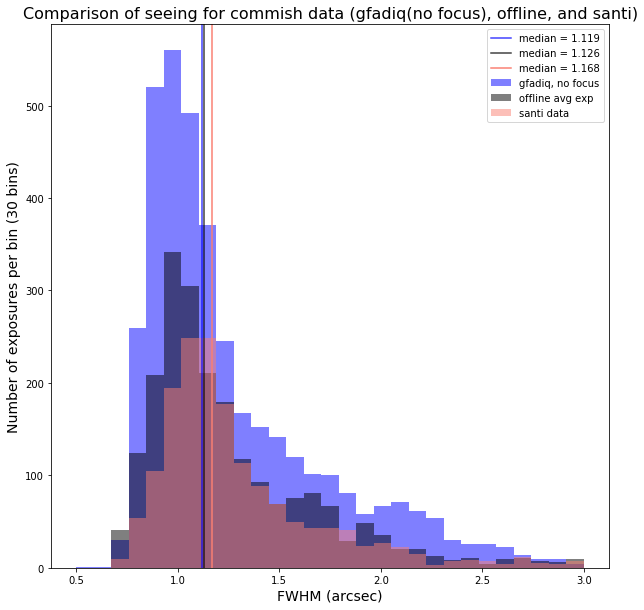

In [30]:
bins = np.linspace(0.5,3,30)
plt.figure(figsize = (10,10))
plt.hist(fwhm_nofocus, bins = bins, color = 'blue', alpha = 0.5, label = 'gfadiq, no focus')
plt.hist(offline_fwhm_avg_per_expid, bins = bins, color = 'black', alpha = 0.5, label = 'offline avg exp')
plt.hist(santi_fwhm, bins = bins, color = 'salmon', alpha = 0.5, label = 'santi data')
plt.axvline(np.nanmedian(fwhm_nofocus), color = 'blue', alpha = 0.75, label = 'median = 1.119')
plt.axvline(np.nanmedian(offline_fwhm_avg_per_expid), color = 'k', alpha = 0.75, label = 'median = 1.126')
plt.axvline(np.nanmedian(santi_fwhm), color = 'salmon', label = 'median = 1.168')
plt.legend()
plt.xlabel('FWHM (arcsec)', fontsize = 14)
plt.ylabel('Number of exposures per bin (30 bins)', fontsize = 14)
plt.title('Comparison of seeing for commish data (gfadiq(no focus), offline, and santi)', fontsize = 16);

### make scatter plots of exposures that gfadiq and offline, and gfadiq and guider have in common

In [31]:
np.unique(offline_expid)

array([20292, 20293, 20294, ..., 54493, 54494, 54495])

In [15]:
gfadiq_expid = nofocus['expid']
print(np.unique(gfadiq_expid))
print(len(np.unique(gfadiq_expid)))

[19992 19993 19996 ... 52627 52658 52678]
3890


In [16]:
gfadiq_fwhm = nofocus['fwhm']

In [243]:
# print(*np.sort(gfadiq_expid), sep=",")

In [161]:
gfa_guider_sim = []
gfa_offline_sim = []
mask = []
for i in range(len(gfadiq_expid)):
    if gfadiq_expid[i] in santi_expid:
        mask.append(True)
        gfa_guider_sim.append(gfadiq_expid[i])
    elif gfadiq_expid[i] not in santi_expid:
        mask.append(False)